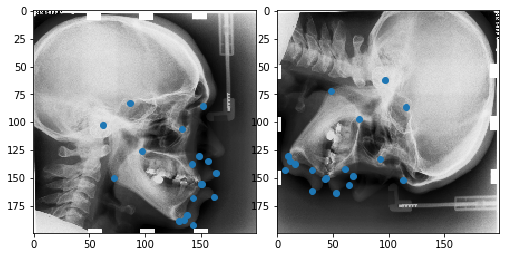

In [30]:
import os
import imgaug
from skimage import io, transform
from skimage import img_as_ubyte
from imgaug import augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import random

# images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
SAMPLE_PATH = "ceph_test_data/001.bmp"
TXT_PATH = "ceph_test_data/001.txt"
# import sample image
img = img_as_ubyte(io.imread(SAMPLE_PATH, as_grey=True))
x,y = img.shape
SCALE = 15
img_dimmed = np.expand_dims(img, axis=0)


def extract_labels_from_txt(path):
    with open(path, "r") as f:
        # only first 19 are actual coords in dataset label files
        coords_raw = f.readlines()[:18]
        coords_raw = [tuple([int(float(s)) for s in t.split(",")]) for t in coords_raw]
        return coords_raw

coords_raw = extract_labels_from_txt(TXT_PATH)

kp_to_list = lambda k_arr: [(p.x, p.y) for p in k_arr]

def list_to_kp(coords_raw):
    kp = []
    for coord in coords_raw:
        kp.append(imgaug.Keypoint(x=coord[0], y=coord[1]))
    keypoints = imgaug.KeypointsOnImage(kp, shape=img.shape)
    return keypoints
    
keypoints_on_images = [list_to_kp(coords_raw)]

rs = iaa.Sequential([iaa.Scale({"height":200, "width":200})])
rs_det = rs.to_deterministic()
seq = iaa.Sequential([iaa.Affine(rotate=90)])
seq_det = seq.to_deterministic() # call this for each batch again, NOT only once at the start

images_rs = rs_det.augment_images(img_dimmed)
keypoints_rs = rs_det.augment_keypoints(keypoints_on_images)
images_aug = seq_det.augment_images(images_rs)
keypoints_aug = seq_det.augment_keypoints(keypoints_rs)

fig = plt.figure()

plt.rcParams["figure.figsize"] = [16,9]
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 1, 1)

ax1.imshow(images_rs[0], cmap="gray")
ax2.imshow(images_aug[0], cmap="gray")

k_orig = kp_to_list(keypoints_rs[0].keypoints)
k_aug = kp_to_list(keypoints_aug[0].keypoints)

ax1.scatter(*zip(*k_orig))
ax2.scatter(*zip(*k_aug))
plt.show()

In [31]:
# okay, next:
# transform to square
# rotate each 3x
# flip each 1x 
# total: get 400*5-> 2000 pics or so
# save as downsized img

BASE_PATH = "/Users/franzr/Desktop/main_code/DENT_NEW/data/data_profile/profile/wang_cephalometrics/RawImage"
BASE_LABELS = "/Users/franzr/Desktop/main_code/DENT_NEW/data/data_profile/profile/wang_cephalometrics/AnnotationsByMD/400_senior"

def img_path_walker(base_path):
    # walk through subdirs to get all image paths
    img_paths = []
    for root, _, files in os.walk(base_path):
        for name in files:
            if name.endswith(".bmp"):
                img_paths.append(os.path.abspath(os.path.join(root, name)))
    return img_paths
    
def label_walker(base_labels):
    img_labels = {}
    for label_file in os.listdir(base_labels):
        linked_img = label_file[:-3] + "bmp"
        img_labels[linked_img] = extract_labels_from_txt(base_labels + "/" + label_file)
    return img_labels

# -1. load labels & transform into keypoint structure
# -2. for aug in augs: 
# --a. augment image & keypoint
# --b. save aug_img & aug_keypoint as 'img + aug_name' & 'kp + aug_name' 
img_labels = label_walker(BASE_LABELS)
img_paths = img_path_walker(BASE_PATH)

shrink = iaa.Scale({"height":224, "width":224})
augment_functions = [iaa.Fliplr(1.0), iaa.Flipud(1.0)]
augment_functions += [iaa.Affine(rotate=rot_angle) for rot_angle in [90, 180, 270]]

def aug_and_save(img, img_name, label, aug_list, base_path):
    kp = [list_to_kp(label)]
    img = shrink.augment_image(img)
    kp = shrink.augment_keypoints(kp)
    img_save_name = base_path + "/" + img_name + "_aug{}".format(0)
    io.imsave(img_save_name + ".png", img)
    with open(img_save_name + ".txt", "w") as lf:
            stringified = [str(tup) for tup in kp_to_list(kp[0].keypoints)]
            stringified = [s.replace("(", "").replace(")","") for s in stringified]
            lf.write("\n".join(stringified))
    for i, aug in enumerate(aug_list):
        img_aug = aug.augment_image(img)
        kp_aug = aug.augment_keypoints(kp)
        # save img:
        img_save_name = base_path + "/" + img_name + "_aug{}".format(i+1)
        io.imsave(img_save_name + ".png", img_aug)
        # save labelfile:
        print img_save_name
        with open(img_save_name + ".txt", "w") as lf:
            stringified = [str(tup) for tup in kp_to_list(kp_aug[0].keypoints)]
            stringified = [s.replace("(", "").replace(")","") for s in stringified]
            lf.write("\n".join(stringified))


for i, path in enumerate(img_paths):
    # import as ubyte if want reduced range for small pics
    # loop_img = img_as_ubyte(io.imread(path, as_grey=True))
    # import normally for resnet-18 attempt:
    loop_img = io.imread(path)
    print loop_img.shape
    loop_labels = img_labels[path.split("/")[-1]]
    aug_and_save(loop_img, path.split("/")[-1][:-4], loop_labels, augment_functions, "aug_img_224")


(2400, 1935, 3)
aug_img_224/151_aug1
aug_img_224/151_aug2
aug_img_224/151_aug3
aug_img_224/151_aug4
aug_img_224/151_aug5
(2400, 1935, 3)
aug_img_224/152_aug1
aug_img_224/152_aug2
aug_img_224/152_aug3
aug_img_224/152_aug4
aug_img_224/152_aug5
(2400, 1935, 3)
aug_img_224/153_aug1
aug_img_224/153_aug2
aug_img_224/153_aug3
aug_img_224/153_aug4
aug_img_224/153_aug5
(2400, 1935, 3)
aug_img_224/154_aug1
aug_img_224/154_aug2
aug_img_224/154_aug3
aug_img_224/154_aug4
aug_img_224/154_aug5
(2400, 1935, 3)
aug_img_224/155_aug1
aug_img_224/155_aug2
aug_img_224/155_aug3
aug_img_224/155_aug4
aug_img_224/155_aug5
(2400, 1935, 3)
aug_img_224/156_aug1
aug_img_224/156_aug2
aug_img_224/156_aug3
aug_img_224/156_aug4
aug_img_224/156_aug5
(2400, 1935, 3)
aug_img_224/157_aug1
aug_img_224/157_aug2
aug_img_224/157_aug3
aug_img_224/157_aug4
aug_img_224/157_aug5
(2400, 1935, 3)
aug_img_224/158_aug1
aug_img_224/158_aug2
aug_img_224/158_aug3
aug_img_224/158_aug4
aug_img_224/158_aug5
(2400, 1935, 3)
aug_img_224/159_

aug_img_224/218_aug5
(2400, 1935, 3)
aug_img_224/219_aug1
aug_img_224/219_aug2
aug_img_224/219_aug3
aug_img_224/219_aug4
aug_img_224/219_aug5
(2400, 1935, 3)
aug_img_224/220_aug1
aug_img_224/220_aug2
aug_img_224/220_aug3
aug_img_224/220_aug4
aug_img_224/220_aug5
(2400, 1935, 3)
aug_img_224/221_aug1
aug_img_224/221_aug2
aug_img_224/221_aug3
aug_img_224/221_aug4
aug_img_224/221_aug5
(2400, 1935, 3)
aug_img_224/222_aug1
aug_img_224/222_aug2
aug_img_224/222_aug3
aug_img_224/222_aug4
aug_img_224/222_aug5
(2400, 1935, 3)
aug_img_224/223_aug1
aug_img_224/223_aug2
aug_img_224/223_aug3
aug_img_224/223_aug4
aug_img_224/223_aug5
(2400, 1935, 3)
aug_img_224/224_aug1
aug_img_224/224_aug2
aug_img_224/224_aug3
aug_img_224/224_aug4
aug_img_224/224_aug5
(2400, 1935, 3)
aug_img_224/225_aug1
aug_img_224/225_aug2
aug_img_224/225_aug3
aug_img_224/225_aug4
aug_img_224/225_aug5
(2400, 1935, 3)
aug_img_224/226_aug1
aug_img_224/226_aug2
aug_img_224/226_aug3
aug_img_224/226_aug4
aug_img_224/226_aug5
(2400, 1935

aug_img_224/287_aug1
aug_img_224/287_aug2
aug_img_224/287_aug3
aug_img_224/287_aug4
aug_img_224/287_aug5
(2400, 1935, 3)
aug_img_224/288_aug1
aug_img_224/288_aug2
aug_img_224/288_aug3
aug_img_224/288_aug4
aug_img_224/288_aug5
(2400, 1935, 3)
aug_img_224/289_aug1
aug_img_224/289_aug2
aug_img_224/289_aug3
aug_img_224/289_aug4
aug_img_224/289_aug5
(2400, 1935, 3)
aug_img_224/290_aug1
aug_img_224/290_aug2
aug_img_224/290_aug3
aug_img_224/290_aug4
aug_img_224/290_aug5
(2400, 1935, 3)
aug_img_224/291_aug1
aug_img_224/291_aug2
aug_img_224/291_aug3
aug_img_224/291_aug4
aug_img_224/291_aug5
(2400, 1935, 3)
aug_img_224/292_aug1
aug_img_224/292_aug2
aug_img_224/292_aug3
aug_img_224/292_aug4
aug_img_224/292_aug5
(2400, 1935, 3)
aug_img_224/293_aug1
aug_img_224/293_aug2
aug_img_224/293_aug3
aug_img_224/293_aug4
aug_img_224/293_aug5
(2400, 1935, 3)
aug_img_224/294_aug1
aug_img_224/294_aug2
aug_img_224/294_aug3
aug_img_224/294_aug4
aug_img_224/294_aug5
(2400, 1935, 3)
aug_img_224/295_aug1
aug_img_224

aug_img_224/355_aug1
aug_img_224/355_aug2
aug_img_224/355_aug3
aug_img_224/355_aug4
aug_img_224/355_aug5
(2400, 1935, 3)
aug_img_224/356_aug1
aug_img_224/356_aug2
aug_img_224/356_aug3
aug_img_224/356_aug4
aug_img_224/356_aug5
(2400, 1935, 3)
aug_img_224/357_aug1
aug_img_224/357_aug2
aug_img_224/357_aug3
aug_img_224/357_aug4
aug_img_224/357_aug5
(2400, 1935, 3)
aug_img_224/358_aug1
aug_img_224/358_aug2
aug_img_224/358_aug3
aug_img_224/358_aug4
aug_img_224/358_aug5
(2400, 1935, 3)
aug_img_224/359_aug1
aug_img_224/359_aug2
aug_img_224/359_aug3
aug_img_224/359_aug4
aug_img_224/359_aug5
(2400, 1935, 3)
aug_img_224/360_aug1
aug_img_224/360_aug2
aug_img_224/360_aug3
aug_img_224/360_aug4
aug_img_224/360_aug5
(2400, 1935, 3)
aug_img_224/361_aug1
aug_img_224/361_aug2
aug_img_224/361_aug3
aug_img_224/361_aug4
aug_img_224/361_aug5
(2400, 1935, 3)
aug_img_224/362_aug1
aug_img_224/362_aug2
aug_img_224/362_aug3
aug_img_224/362_aug4
aug_img_224/362_aug5
(2400, 1935, 3)
aug_img_224/363_aug1
aug_img_224

aug_img_224/024_aug1
aug_img_224/024_aug2
aug_img_224/024_aug3
aug_img_224/024_aug4
aug_img_224/024_aug5
(2400, 1935, 3)
aug_img_224/025_aug1
aug_img_224/025_aug2
aug_img_224/025_aug3
aug_img_224/025_aug4
aug_img_224/025_aug5
(2400, 1935, 3)
aug_img_224/026_aug1
aug_img_224/026_aug2
aug_img_224/026_aug3
aug_img_224/026_aug4
aug_img_224/026_aug5
(2400, 1935, 3)
aug_img_224/027_aug1
aug_img_224/027_aug2
aug_img_224/027_aug3
aug_img_224/027_aug4
aug_img_224/027_aug5
(2400, 1935, 3)
aug_img_224/028_aug1
aug_img_224/028_aug2
aug_img_224/028_aug3
aug_img_224/028_aug4
aug_img_224/028_aug5
(2400, 1935, 3)
aug_img_224/029_aug1
aug_img_224/029_aug2
aug_img_224/029_aug3
aug_img_224/029_aug4
aug_img_224/029_aug5
(2400, 1935, 3)
aug_img_224/030_aug1
aug_img_224/030_aug2
aug_img_224/030_aug3
aug_img_224/030_aug4
aug_img_224/030_aug5
(2400, 1935, 3)
aug_img_224/031_aug1
aug_img_224/031_aug2
aug_img_224/031_aug3
aug_img_224/031_aug4
aug_img_224/031_aug5
(2400, 1935, 3)
aug_img_224/032_aug1
aug_img_224

aug_img_224/092_aug1
aug_img_224/092_aug2
aug_img_224/092_aug3
aug_img_224/092_aug4
aug_img_224/092_aug5
(2400, 1935, 3)
aug_img_224/093_aug1
aug_img_224/093_aug2
aug_img_224/093_aug3
aug_img_224/093_aug4
aug_img_224/093_aug5
(2400, 1935, 3)
aug_img_224/094_aug1
aug_img_224/094_aug2
aug_img_224/094_aug3
aug_img_224/094_aug4
aug_img_224/094_aug5
(2400, 1935, 3)
aug_img_224/095_aug1
aug_img_224/095_aug2
aug_img_224/095_aug3
aug_img_224/095_aug4
aug_img_224/095_aug5
(2400, 1935, 3)
aug_img_224/096_aug1
aug_img_224/096_aug2
aug_img_224/096_aug3
aug_img_224/096_aug4
aug_img_224/096_aug5
(2400, 1935, 3)
aug_img_224/097_aug1
aug_img_224/097_aug2
aug_img_224/097_aug3
aug_img_224/097_aug4
aug_img_224/097_aug5
(2400, 1935, 3)
aug_img_224/098_aug1
aug_img_224/098_aug2
aug_img_224/098_aug3
aug_img_224/098_aug4
aug_img_224/098_aug5
(2400, 1935, 3)
aug_img_224/099_aug1
aug_img_224/099_aug2
aug_img_224/099_aug3
aug_img_224/099_aug4
aug_img_224/099_aug5
(2400, 1935, 3)
aug_img_224/100_aug1
aug_img_224

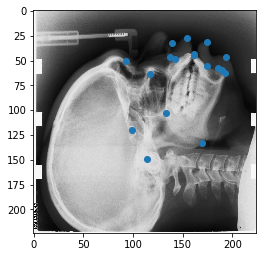

In [36]:
test = io.imread("/Users/franzr/Desktop/Dent_PJ_Stuff/dl_progression/aug_img_224/120_aug5.png", as_grey=True)
cr = extract_labels_from_txt("/Users/franzr/Desktop/Dent_PJ_Stuff/dl_progression/aug_img_224/120_aug5.txt")

fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.imshow(test, cmap="gray")
ax.scatter(*zip(*cr))
plt.show()
